In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import *

In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

epochs = 20
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [9]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [10]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [11]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = resnet18(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [13]:
# model.eval()
for i in model.parameters():
    pass
#     print(i.shape)
#     print((i[0].type()))
state_dict = model.state_dict()
for i in state_dict :
    print(i)
#     if 'conv1.weight' in i :
#         print(state_dict[i][0,0])

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

In [14]:
# optimizer
# optimizer = optim.Adam(model.parameters(), lr=5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [15]:
# training function
def fit(model, dataloader):
#     print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [16]:
#validation function
def validate(model, dataloader):
#     print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [17]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

  0%|          | 0/94 [00:00<?, ?it/s]

Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20


95it [00:17,  5.45it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  5.94it/s]

Train Loss: 0.0579, Train Acc: 23.28


15it [00:02,  6.16it/s]                        
  1%|          | 1/94 [00:00<00:16,  5.59it/s]

Val Loss: 0.0565, Val Acc: 27.33
Epoch 2 of 20


95it [00:16,  5.64it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.10it/s]

Train Loss: 0.0465, Train Acc: 34.37


15it [00:02,  7.18it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.40it/s]

Val Loss: 0.0482, Val Acc: 38.09
Epoch 3 of 20


95it [00:16,  5.82it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.39it/s]

Train Loss: 0.0394, Train Acc: 42.04


15it [00:02,  7.34it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.73it/s]

Val Loss: 0.0405, Val Acc: 45.33
Epoch 4 of 20


95it [00:16,  5.65it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.23it/s]

Train Loss: 0.0342, Train Acc: 48.61


15it [00:02,  6.97it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.28it/s]

Val Loss: 0.0396, Val Acc: 46.76
Epoch 5 of 20


95it [00:16,  5.64it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.34it/s]

Train Loss: 0.0302, Train Acc: 53.40


15it [00:02,  7.23it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.52it/s]

Val Loss: 0.0347, Val Acc: 50.27
Epoch 6 of 20


95it [00:16,  5.65it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.24it/s]

Train Loss: 0.0260, Train Acc: 58.75


15it [00:02,  7.15it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.70it/s]

Val Loss: 0.0317, Val Acc: 55.43
Epoch 7 of 20


95it [00:16,  5.63it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.22it/s]

Train Loss: 0.0229, Train Acc: 62.80


15it [00:02,  7.23it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.71it/s]

Val Loss: 0.0330, Val Acc: 54.12
Epoch 8 of 20


95it [00:16,  5.71it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.40it/s]

Train Loss: 0.0195, Train Acc: 68.09


15it [00:01,  7.85it/s]                        
  1%|          | 1/94 [00:00<00:13,  7.06it/s]

Val Loss: 0.0287, Val Acc: 58.95
Epoch 9 of 20


95it [00:16,  5.64it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.20it/s]

Train Loss: 0.0157, Train Acc: 74.39


15it [00:02,  6.98it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.46it/s]

Val Loss: 0.0279, Val Acc: 59.39
Epoch 10 of 20


95it [00:16,  5.64it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.40it/s]

Train Loss: 0.0126, Train Acc: 80.06


15it [00:02,  7.24it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.72it/s]

Val Loss: 0.0284, Val Acc: 57.96
Epoch 11 of 20


95it [00:16,  5.67it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.29it/s]

Train Loss: 0.0095, Train Acc: 85.33


15it [00:02,  7.28it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.22it/s]

Val Loss: 0.0296, Val Acc: 58.73
Epoch 12 of 20


95it [00:16,  5.61it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.29it/s]

Train Loss: 0.0063, Train Acc: 91.04


15it [00:01,  7.54it/s]                        
  1%|          | 1/94 [00:00<00:12,  7.72it/s]

Val Loss: 0.0287, Val Acc: 59.71
Epoch 13 of 20


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  6.66it/s]

Train Loss: 0.0043, Train Acc: 94.76


15it [00:01,  7.88it/s]                        
  1%|          | 1/94 [00:00<00:11,  8.41it/s]

Val Loss: 0.0262, Val Acc: 60.04
Epoch 14 of 20


95it [00:16,  5.72it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.09it/s]

Train Loss: 0.0024, Train Acc: 98.14


15it [00:02,  6.30it/s]                        
  1%|          | 1/94 [00:00<00:16,  5.68it/s]

Val Loss: 0.0243, Val Acc: 65.86
Epoch 15 of 20


95it [00:16,  5.62it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.08it/s]

Train Loss: 0.0010, Train Acc: 99.51


15it [00:02,  6.95it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.84it/s]

Val Loss: 0.0220, Val Acc: 67.51
Epoch 16 of 20


95it [00:16,  5.62it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.45it/s]

Train Loss: 0.0005, Train Acc: 99.98


15it [00:02,  7.16it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.27it/s]

Val Loss: 0.0215, Val Acc: 68.61
Epoch 17 of 20


95it [00:16,  5.63it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.31it/s]

Train Loss: 0.0003, Train Acc: 99.98


15it [00:02,  6.93it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.74it/s]

Val Loss: 0.0207, Val Acc: 68.50
Epoch 18 of 20


95it [00:16,  5.65it/s]                        
  0%|          | 0/14 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 99.95


15it [00:02,  7.06it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.48it/s]

Val Loss: 0.0209, Val Acc: 68.50
Epoch 19 of 20


95it [00:16,  5.85it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.13it/s]

Train Loss: 0.0002, Train Acc: 99.97


15it [00:01,  7.71it/s]                        
  1%|          | 1/94 [00:00<00:12,  7.40it/s]

Val Loss: 0.0224, Val Acc: 67.84
Epoch 20 of 20


95it [00:16,  5.66it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  6.56it/s]

Train Loss: 0.0003, Train Acc: 99.90


15it [00:02,  7.22it/s]                        


Val Loss: 0.0228, Val Acc: 67.40
6.303060853481293 minutes


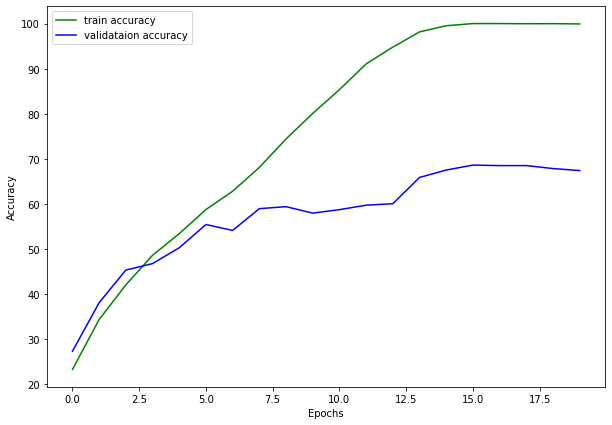

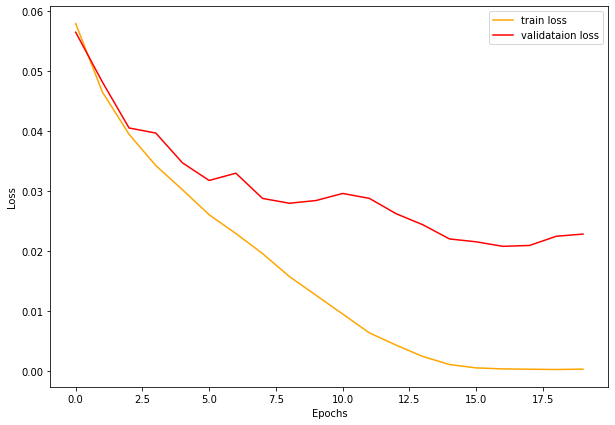

In [18]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')
torch.save(model.state_dict(), f"../trained_models/resnet18_epochs{epochs}.pth")
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/plots/loss.png')

In [19]:
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of the network on test images: 67.927 %
train.py finished running


In [20]:
state_dict = model.state_dict()
for i in state_dict :
#     print(i)
    if 'conv1.weight' in i :
        print(state_dict[i][0,0])

tensor([[-0.0596, -0.1231, -0.0444,  0.0202,  0.0307,  0.0295,  0.0558],
        [-0.0496, -0.0795, -0.0920, -0.0135,  0.1006,  0.0606,  0.1003],
        [-0.1009, -0.1414, -0.0639, -0.0201,  0.1122,  0.1010,  0.0799],
        [-0.0548, -0.0732, -0.0260,  0.0209,  0.0916,  0.0543,  0.0611],
        [-0.1131, -0.0878, -0.0492,  0.0320,  0.0173,  0.0395,  0.0585],
        [-0.0542, -0.1132, -0.0096,  0.0922,  0.0144,  0.0015, -0.0099],
        [ 0.0230, -0.0363, -0.0009,  0.0661,  0.0358,  0.0084, -0.0462]],
       device='cuda:0')
tensor([[-0.0457, -0.1732, -0.1504],
        [-0.0242, -0.1036,  0.0144],
        [-0.1017,  0.0192, -0.1163]], device='cuda:0')
tensor([[-0.0026, -0.0225, -0.0238],
        [ 0.1231, -0.0619,  0.0640],
        [ 0.0362, -0.0078, -0.0361]], device='cuda:0')
tensor([[-0.0370,  0.0495, -0.0495],
        [-0.0810, -0.0018,  0.0354],
        [-0.0654,  0.0169,  0.0122]], device='cuda:0')
tensor([[-0.0443,  0.0379,  0.0663],
        [-0.0491, -0.0058,  0.0786],
   